In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

from sklearn.datasets import make_moons

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.datasets import load_wine

In [2]:
RANDOM_STATE = 42

In [3]:
def displayScatter(X, color=None, title=None):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=color)
    plt.title(title)
    plt.show()

# Données

In [4]:
def halfMoons(n_samples, noise):
    return make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=RANDOM_STATE)

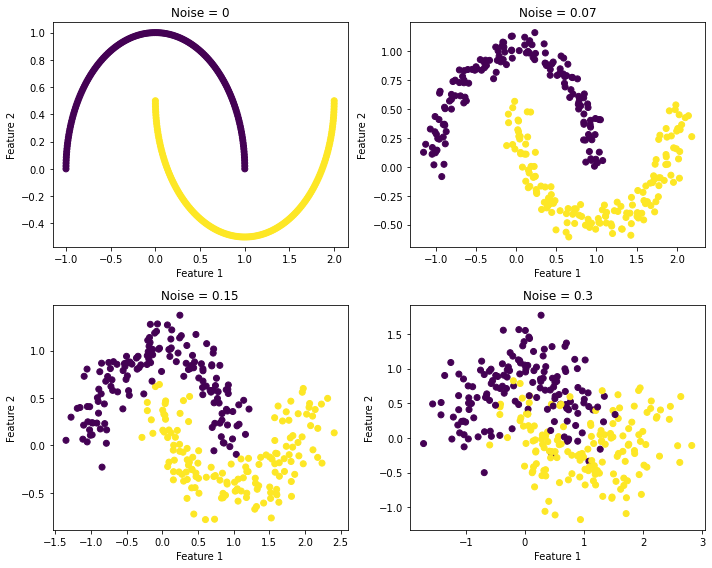

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Génération et affichage des demi-lunes avec différents niveaux de bruit
noise_levels = [0, 0.07, 0.15, 0.3]
for i, noise in enumerate(noise_levels):
    X, y = halfMoons(300, noise)
    ax = axes[i // 2, i % 2]
    ax.scatter(X[:, 0], X[:, 1], c=y)
    ax.set_title(f'Noise = {noise}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

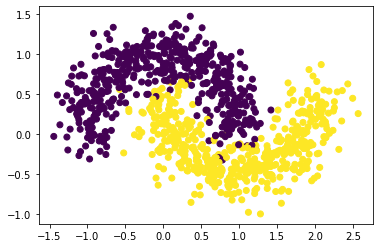

In [6]:
X, y = halfMoons(1000, 0.2)
displayScatter(X, y)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

# Classifieurs

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)

In [9]:
cl_knn = KNeighborsClassifier(n_neighbors=3)
cl_knn.fit(Xtrain, ytrain)
yhat = cl_knn.predict(Xtest)
print(classification_report(ytest, yhat))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.96      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



In [10]:
cl_svm = SVC()
cl_svm.fit(Xtrain, ytrain)
yhat = cl_svm.predict(Xtest)
print(classification_report(ytest, yhat))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       0.96      0.97      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



In [11]:
cl_rf = RandomForestClassifier()
cl_rf.fit(Xtrain, ytrain)
yhat = cl_rf.predict(Xtest)
print(classification_report(ytest, yhat))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.96      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



# Génération d'exemples contrefactuels

In [12]:
def SL(x, a0, a1, n):
    d = len(x)
    z = np.random.normal(loc=0, scale=1, size=(n, d))
    z /= np.linalg.norm(z, axis=1).reshape(-1, 1)
    
    u = np.random.uniform(low=a0**d, high=a1**d, size=(n, 1))
    u = np.power(u, 1/d)
    
    return x + z * u

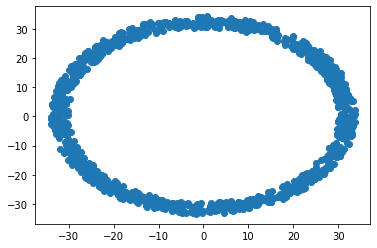

In [13]:
sl_x0 = SL(X[0], 30, 34, 1000)
displayScatter(sl_x0)

In [14]:
zhat = np.array([1, 2, 1, 4, 1])

In [15]:
zhat[np.where((zhat != 1))[0]]

array([2, 4])

In [16]:
def gs_generation(gs_model, x, eta, n):
    f_x = gs_model.predict([x])[0]
    
    z = SL(x, 0, eta, n)
    zhat = gs_model.predict(z)
    
    while (zhat != f_x).any():
        eta /= 2
        z = SL(x, 0, eta, n)
        zhat = gs_model.predict(z)
        
    a0 = eta
    a1 = 2 * eta
    
    while not (zhat != f_x).any():
        z = SL(x, a0, a1, n)
        zhat = gs_model.predict(z)
        
        a0 = a1
        a1 += eta
        
    es = z[np.where((zhat != f_x))[0]]
    dists = [np.linalg.norm(x - e) for e in es]
    
    e_min = np.argmin(dists)
    return es[e_min], dists[e_min]

In [17]:
e, d_e = gs_generation(cl_knn, X[0], 2, 100)
print(e, d_e)

[-0.16650179  0.51463632] 0.05511917168750328


In [18]:
X[0]

array([-0.11166654,  0.52022374])

In [19]:
cl_knn.predict([X[0]])[0]

1

In [20]:
cl_knn.predict([X[0], e])

array([1, 0])

In [21]:
def gs_feature_selection(model, x, e):
    
    f_x = model.predict([x])[0]
    e_opti = None
    
    e_prime = e.copy()
    f_e_prime = model.predict([e_prime])[0]
    
    while f_e_prime != f_x:
        e_opti = e_prime.copy()
        
        arr = np.abs(e_prime - x)
        nz_ind = np.where(arr != 0)
        i = nz_ind[0][np.argmin(arr[nz_ind])]
        
        e_prime[i] = x[i]
        f_e_prime = model.predict([e_prime])
    
    return e_opti

In [22]:
e_opt = gs_feature_selection(cl_knn, X[0], e)
e_opt

array([-0.16650179,  0.51463632])

In [23]:
cl_knn.predict([X[0], e_opt])

array([1, 0])

# Visualisation

In [24]:
def visualize_contrefactuel(model, X, y, index, contrefactuel, ax, classes=[0, 1], title="", label=True):
    
        data_to_explain = X[index]
    
        colors = ["navajowhite", "powderblue"]
        classes = classes

        ax.set_title(title)

        y = y.reshape(-1)
        for j, cl in enumerate(classes):
            X_cl = X[y == cl]
            ax.scatter(
                X_cl[:, 0],
                X_cl[:, 1],
                c=colors[j],
                label=f"Classe : {cl}" if label else "",
            )

        mmax = X.max(0)
        mmin = X.min(0)

        step = 1000
        x1grid, x2grid = np.meshgrid(
            np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step)
        )

        grid = np.hstack(
            (x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1))
        )

        res = model.predict(grid)
        res = res.reshape(x1grid.shape)

        ax.contourf(
            x1grid,
            x2grid,
            res,
            colors=colors,
            levels=[-1000, 0, 1000],
            alpha=0.4,
        )

        cf_class = model.predict([contrefactuel])[0]
        x_class = model.predict([data_to_explain])[0]
        
        ax.scatter(contrefactuel[0], contrefactuel[1], marker="x", s=200, c='firebrick', label=f"contre factuel" if label else "")
        ax.scatter(data_to_explain[0], data_to_explain[1], marker="+", s=200, c='indigo', label=f"exemple" if label else "")

In [25]:
def get_contrefactuel(gs_model, X, y, index, ax, title="", eta=3, n=100, classes=[0, 1], label=True, visual=True):
    e, d_e = gs_generation(gs_model, X[index], eta, n)
    e_opt = gs_feature_selection(gs_model, X[index], e)
    
    if visual:
        visualize_contrefactuel(gs_model, X, y, index, e_opt, ax, classes=classes, title=title, label=label)
        
    return e_opt

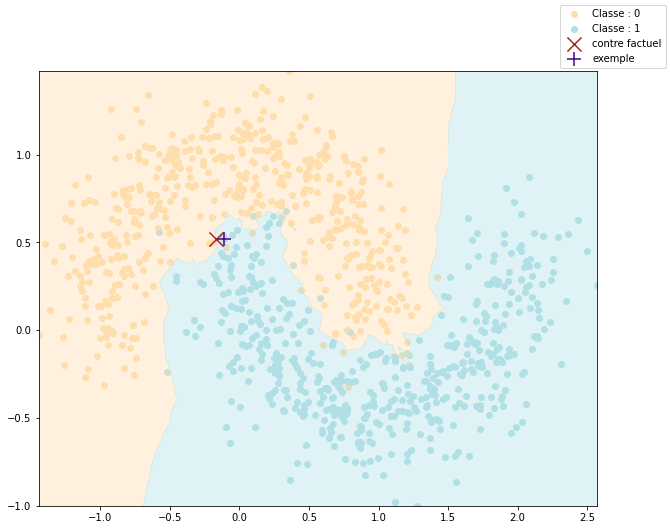

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
get_contrefactuel(cl_knn, X, y, 0, ax)
fig.legend()

In [27]:
def train_model(model, X, y, verbose=True):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)
    model.fit(Xtrain, ytrain)
    yhat = model.predict(Xtest)
    
    if verbose:
        print(classification_report(ytest, yhat))
    
    return model

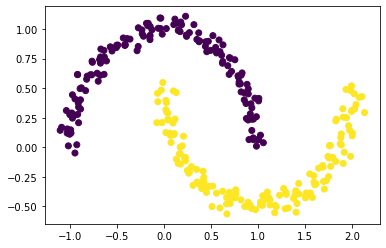

In [28]:
X, y = halfMoons(300, 0.05)
displayScatter(X, y)

In [29]:
model_svm = train_model(SVC(), X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



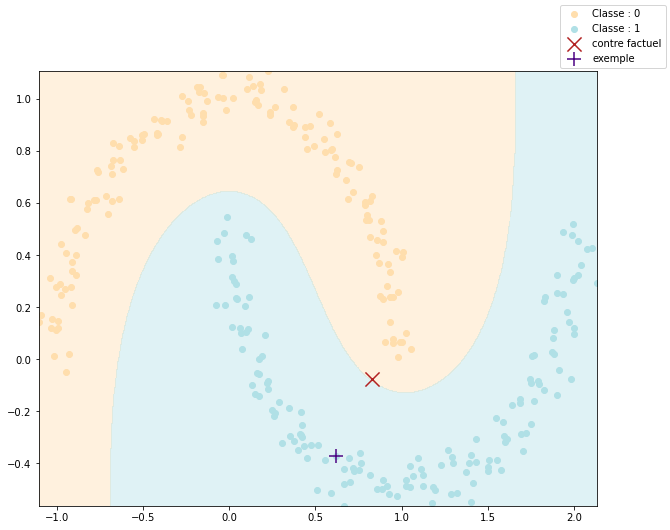

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
get_contrefactuel(model_svm, X, y, 0, ax)
fig.legend()

## Expérimentations sur des données artificielles

## 1- Variation de la composante aléatoire (noise)

Nous avons généré plusieurs ensembles de données artificielles en utilisant différents niveaux de bruit pour créer des scénarios présentant différentes complexités en termes de frontières de décision.

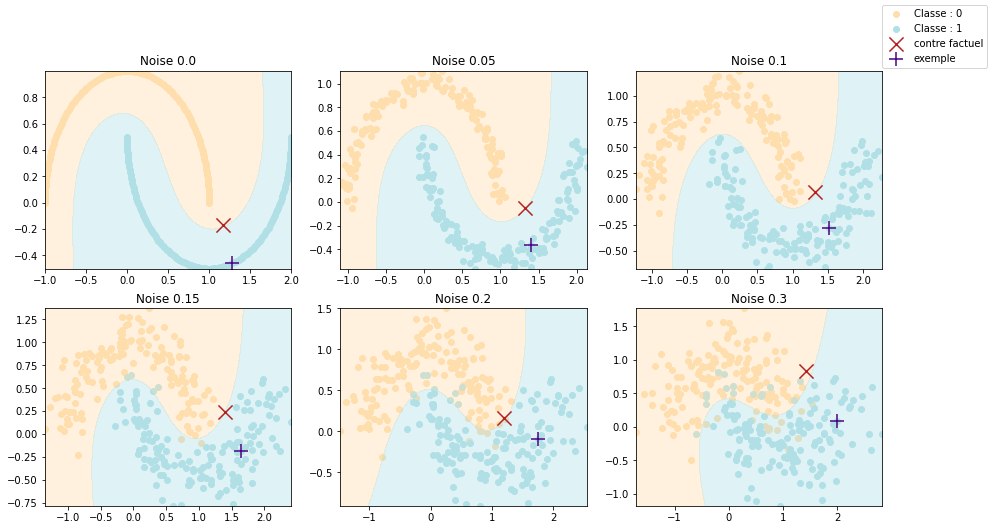

In [31]:
noises = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]  # Différents niveaux de bruit à tester
indice = 29
model = SVC()
n_samples = 300

nrows = len(noises) // 3
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))

i = 0
j = 0

for noise in noises:
    # Génération de points et entrainement du model
    X, y = halfMoons(n_samples=n_samples, noise=noise)    
    model_t = train_model(model, X, y, verbose=False)
    
    get_contrefactuel(model_t, X, y, indice, axs[i][j], title=f"Noise {noise}", label= (i == 0 and j == 0))
    
    j += 1
    if j == ncols:
        i += 1
        j = 0
        
fig.legend()

### Analyse et commentaires

Nous observons que lorsque nous modifions le niveau de bruit dans les bases de données, nous obtenons des contrefactuels différents. Cela s'explique par le fait que la frontière de décision varie d'un jeu de données à un autre.

## 2- Variation de la donnée à expliquer

Cette fois-ci, nous avons choisi plusieurs données à expliquer, et pour chacune de ces données, nous avons généré des exemples contrefactuels.

In [52]:
indices = [0, 50, 100, 29]

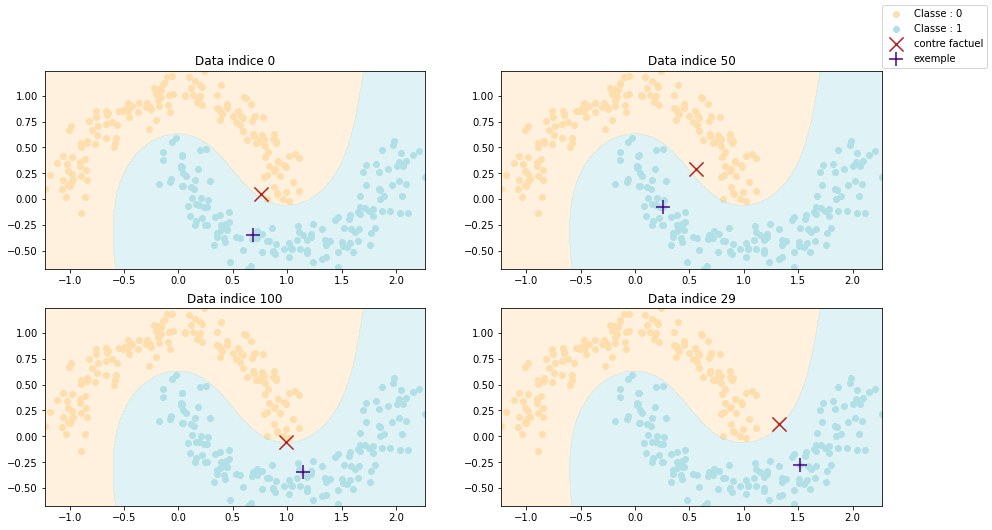

In [53]:
X, y = halfMoons(n_samples=300, noise=0.1)    
model = SVC()
model_t = train_model(model, X, y, verbose=False)

nrows = len(indices) // 2
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))


i = 0
j = 0

for indice in indices:
    get_contrefactuel(model_t, X, y, indice, axs[i][j], title=f"Data indice {indice}", label= (i == 0 and j == 0))
    
    j += 1
    if j == ncols:
        i += 1
        j = 0
    
fig.legend()

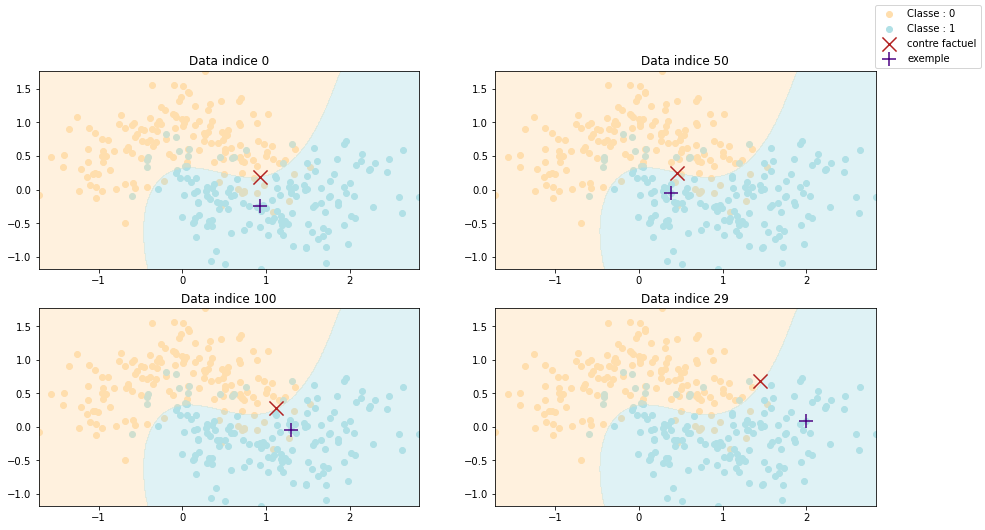

In [54]:
X, y = halfMoons(n_samples=300, noise=0.3)    
model = SVC()
model_t = train_model(model, X, y, verbose=False)

nrows = len(indices) // 2
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))


i = 0
j = 0

for indice in indices:
    get_contrefactuel(model_t, X, y, indice, axs[i][j], title=f"Data indice {indice}", label= (i == 0 and j == 0))

    j += 1
    if j == ncols:
        i += 1
        j = 0
        
fig.legend()

### Analyse et commentaires

Dans cette expérience, nous avons sélectionné plusieurs points à l'intérieur d'un même ensemble de données. Nous avons observé que pour chaque exemple que nous souhaitions expliquer, nous obtenions des contrefactuels différents. De plus, nous avons remarqué que le contrefactuel obtenu se trouvait généralement à la limite de la frontière de décision, ce qui signifie qu'il s'agissait du point le plus proche de la classe opposée.

## 3- Variation du classifieur

In [55]:
indices = [50, 100, 250]

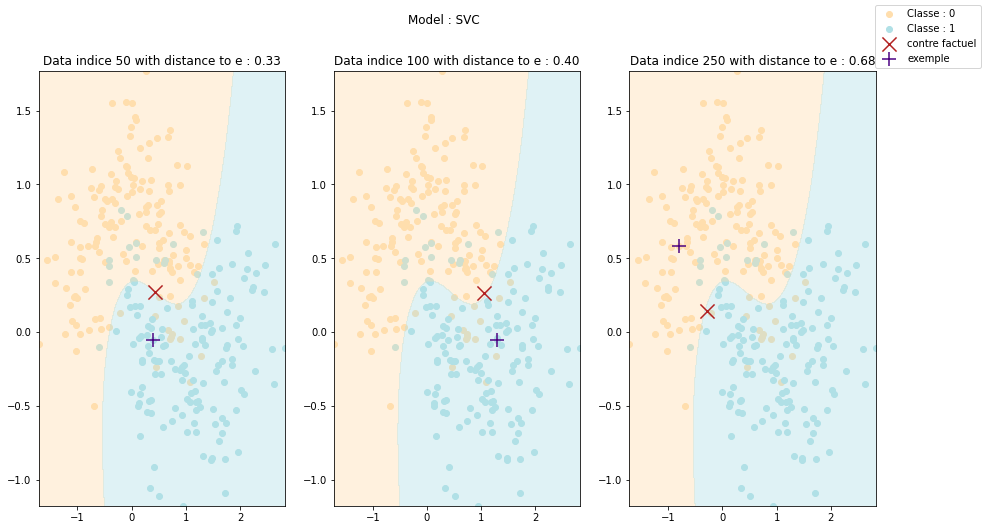

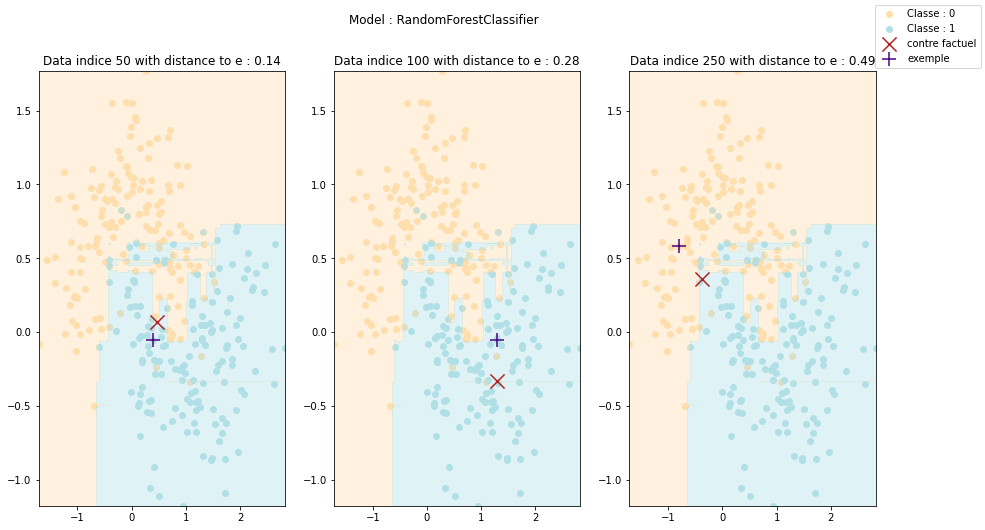

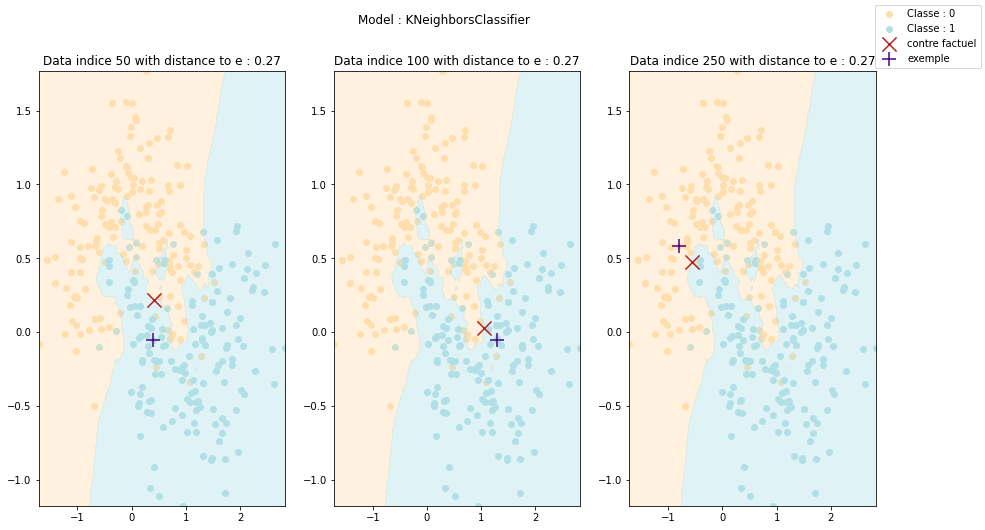

In [56]:
X, y = halfMoons(n_samples=300, noise=0.3)

models = [SVC(), RandomForestClassifier(n_estimators=7), KNeighborsClassifier(n_neighbors=3)]

for model in models:
    model_t = train_model(model, X, y, verbose=False)

    fig, axs = plt.subplots(nrows=1, ncols=len(indices), figsize=(15, 8))


    i = 0
    for indice in indices:
        e = get_contrefactuel(model_t, X, y, indice, axs[i], title=f"Data indice {indice}", label= (i == 0))
        
        dist = np.linalg.norm(e - X[indice])
        axs[i].set_title(f"Data indice {indice} with distance to e : {dist:.2f}")
    
        i += 1
            
    fig.suptitle(f"Model : {type(model).__name__}")
    fig.legend()

In [98]:
moyens = [0, 0, 0]
for im, model in enumerate(models):
    
    for indice in range(len(X)):
        e = get_contrefactuel(model, X, y, indice, None, visual=False)
        dist = np.linalg.norm(e - X[indice])
        moyens[im] += dist

In [100]:
moyens = np.array(moyens)

In [106]:
print("La moyenne des distances par rapport au contrefactuel des exemples du dataset: ")

dists =  moyens / len(X)

print("Pour SVM :", dists[0])
print("Pour RandomForest :", dists[1])
print("Pour KNN :", dists[2])

La moyenne des distances par rapport au contrefactuel des exemples du dataset: 
Pour SVM : 0.6374566297208372
Pour RandomForest : 0.3803473836561077
Pour KNN : 0.42864590697293165


### Analyse et commentaires

Dans la dernière expérience, nous avons choisi de tester différents modèles, en utilisant 3 modèles différents. Nous avons observé que chacun de ces modèles définissait une frontière de décision distincte, ce qui entraînait des contrefactuels différents pour chaque point, en fonction du modèle choisi. Pour comparer les différents résultats, nous avons utilisé la distance euclidienne comme métrique.

Chaque ligne du graphique représente un modèle, tandis que chaque colonne correspond à un exemple du jeu de données à expliquer. En examinant les résultats pour un exemple spécifique, on observe que la distance entre les prédictions des modèles et le contrefactuel varie en fonction du modèle choisi. Pour déterminer le meilleur modèle adapté à ce jeu de données particulier, nous calculons la moyenne des distances par rapport au contrefactuel. Il en ressort que le modèle Random Forest affiche les distances les plus petites. Il est cependant essentiel de vérifier que les prédictions du modèle sont correctes pour les contrefactuels afin de confirmer cette conclusion.

## Expérimentations sur données classiques

Ce jeu de données concerne la description de trois types de vin. Nous allons maintenant appliquer les méthodes de recherche de contrefactuel en utilisant le modèle KNN avec k = 3.

#### Wine

In [108]:
wine = load_wine()
X_wine = wine['data']
y_wine = wine['target']

print("Nombre de classes :", len(np.unique(y_wine)))
print("Nombre de d'exemples :", len(y_wine))
X_wine.shape

Nombre de classes : 3
Nombre de d'exemples : 178


(178, 13)

In [109]:
wine["feature_names"]

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [110]:
# Vérification du bon type (pas de traitement nlp à faire)
for i in range(X_wine.shape[1]):
    if type(X_wine[:,i]) != np.ndarray:
        print("Type error")

In [113]:
# Créer un modèle KNN pour la classification
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_wine, y_wine)

KNeighborsClassifier(n_neighbors=3)

In [115]:
# Choisir une observation à expliquer
index_to_explain = 29

# Générer des exemples contrefactuels pour l'observation sélectionnée
counterfactual = get_contrefactuel(model, X_wine, y_wine, index_to_explain, None, visual=False)

data_to_explain = X_wine[index_to_explain]
print("Les caractéristiques à changer :")

for i in range(X_wine.shape[1]):
    if data_to_explain[i] != counterfactual[i]:
        print(wine["feature_names"][i]," : ", data_to_explain[i],"==>", counterfactual[i])

Les caractéristiques à changer :
magnesium  :  96.0 ==> 159.6452218078929
proline  :  1035.0 ==> 992.2187470873587


### Analyse et commentaires

Dans cette expérience, nous avons affiché les différentes modifications nécessaires pour pouvoir faire passer un exemple d'une classe à une autre.